# Optimisation of risk budget

The value of risk to the bank is -> risk = credit_amount * POD 

We will treat the test dataset as our hypothetical **"prospective clients"** and calculate the interest charges and risk for each client. 

Then I will double this dataset, assume this is the prospective loan clientbase, and run the optimisation on these clients.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
data = pd.read_csv('data/data_with_pod.csv')[['duration','credit_amount','POD']]
data

,duration,credit_amount,POD
0,4,3380,0.0567
1,48,18424,0.9575
2,12,3017,0.6109
3,12,3386,0.1163
4,24,1559,0.4097
...,...,...,...
295,24,1216,0.6659
296,18,1817,0.3256
297,24,2463,0.1714
298,18,8471,0.7434


In [4]:
# Calculate the risk factor for every client
data['Risk'] = data['credit_amount']*np.power(data['POD'], 1.5)

# Calcualte the interest rate charges
def interest_rate(row):
    time_interest = 0.02
    duration = row['duration']
    if duration>10:
        time_interest += np.ceil((duration-10)/10)
    
    pod_interest = 0
    pod = row['POD']
    if pod>0.1:
        pod_interest += np.exp((pod-0.1)*5)
        
    return time_interest + pod_interest

data['Interest Rate'] = data.apply(interest_rate, axis=1)

# The interest amount
data['Interest Amount'] = data['Interest Rate']*data['credit_amount']

data.head()

,duration,credit_amount,POD,Risk,Interest Rate,Interest Amount
0,4,3380,0.0567,45.6605,0.0200,67.6000
1,48,18424,0.9575,17263.0663,76.8181,1415296.7423
2,12,3017,0.6109,1440.6371,13.8863,41895.0261
3,12,3386,0.1163,134.3710,2.1052,7128.0534
4,24,1559,0.4097,408.8235,6.7243,10483.1400


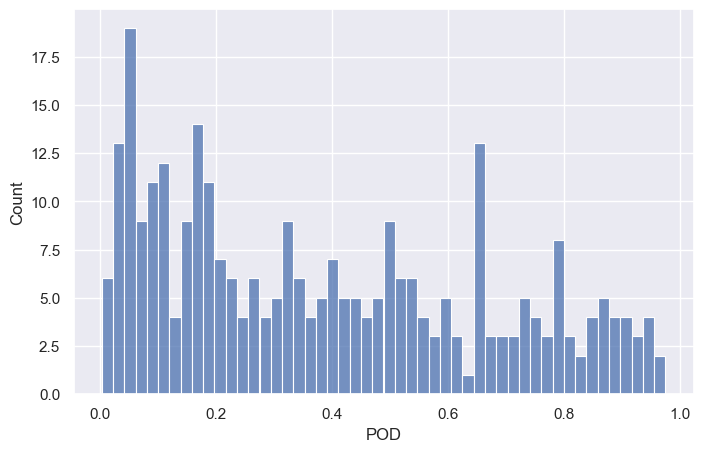

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(data=data, x="POD", bins=50)
plt.show()

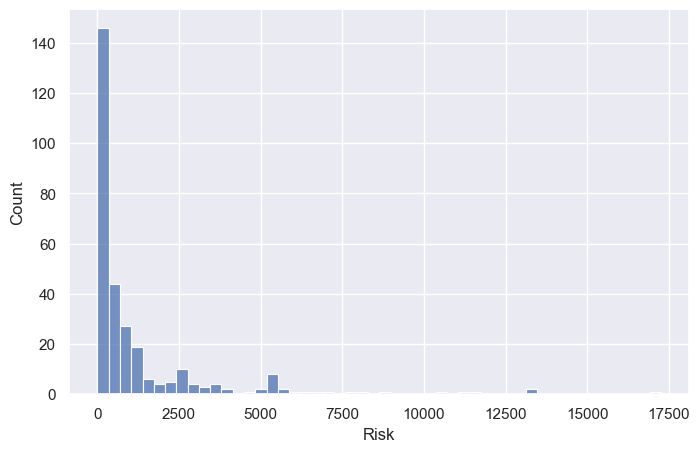

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(data=data, x="Risk", bins=50)
plt.show()

# Maximum POD threshold
In the notebook we found that the most accurate cutoff probability threshold for default is 0.416, meaning that clients with a POD of over 0.416 can be assumed to default on their loan. 

For a little bit of additional risk and reward I will raise the maximum POD tolerance to 0.466 which is 5% more than 0.466.

In [7]:
new_client = data[data['POD']<=0.466]
new_client = pd.concat([new_client, new_client])
new_client

,duration,credit_amount,POD,Risk,Interest Rate,Interest Amount
0,4,3380,0.0567,45.6605,0.0200,67.6000
3,12,3386,0.1163,134.3710,2.1052,7128.0534
4,24,1559,0.4097,408.8235,6.7243,10483.1400
6,36,8229,0.4460,2450.6962,8.6595,71259.0078
7,6,2080,0.0278,9.6226,0.0200,41.6000
...,...,...,...,...,...,...
291,6,3518,0.1538,212.2018,1.3287,4674.3108
293,12,639,0.4167,171.9102,5.8930,3765.6254
296,18,1817,0.3256,337.6081,4.1097,7467.3487
297,24,2463,0.1714,174.7858,3.4491,8495.0933


# Integer optimisation

Each of 370 clients can be offered the loan or not offered the loan. Maximise the intrest earned for a risk range of 50,000 - 60,000

x will be the vector of decision variables, where 1 indicates a loan was offered and 0 the loan was rejected.

In [8]:
print(new_client['Risk'].sum())
print(new_client['Interest Amount'].sum())

105258.60016728226
3464561.2323126453


In [9]:
from scipy.optimize import LinearConstraint
from scipy.optimize import milp

In [10]:
ia = np.array(new_client['Interest Amount'])
r = np.array(new_client['Risk'])

In [11]:
# minimize interest amount
# c@x
c = -ia

# such that:
# x is a vector of 1 and 0 for each client
# b_l <= A @ x <= b_u
A = np.identity(c.shape[0])
b_l = np.zeros_like(c)
b_u = np.ones_like(c)
constraint_1 = LinearConstraint(A=A, lb=b_l, ub=b_u)

# risk is between 50,000 and 60,000
# b_l <= A @ x <= b_u
constraint_2 = LinearConstraint(A=r, lb=50000, ub=60000)

In [12]:
integrality = np.ones_like(c)

In [13]:
res = milp(c=c, constraints=[constraint_1, constraint_2], integrality=integrality)
x = res.x
print(res.message)
print(res.status)
print(f'Total profit from interest: {-c@x:.4f}')
print(f'Total risk: {r@x:.4f}')
print(f'No. clients who were approved: {sum(x)}')

Optimization terminated successfully. (HiGHS Status 7: Optimal)
0
Total profit from interest: 2470175.8540
Total risk: 59999.0241
No. clients who were approved: 213.0


## Colllect the data and visualise the clients whose credit applications were approved

In [14]:
new_client = new_client.assign(credit_approved=x)
approved_client = new_client[new_client.credit_approved==1].reset_index()

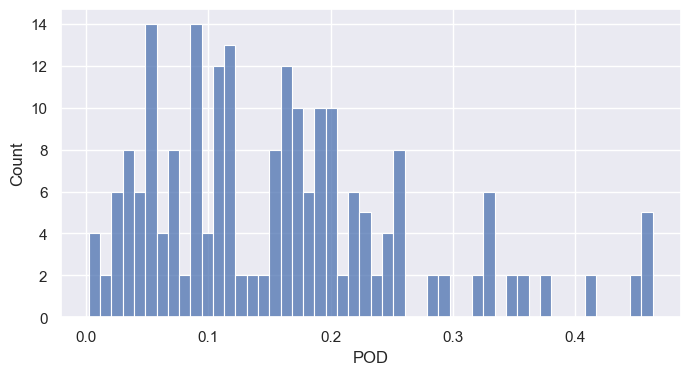

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(data=approved_client, x="POD", bins=50)
plt.show()

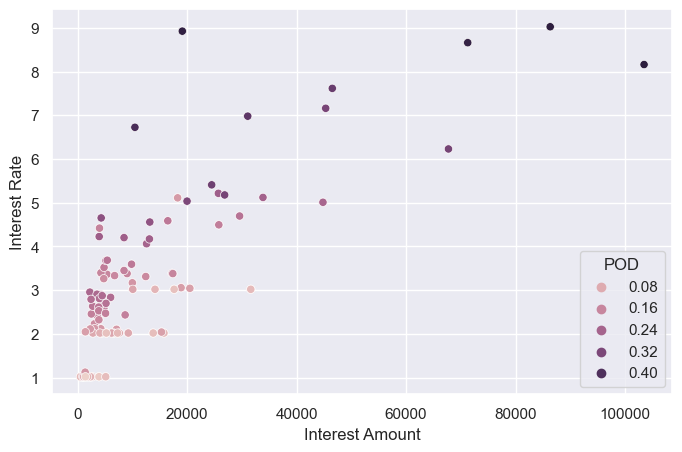

In [16]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=approved_client, x="Interest Amount", y="Interest Rate", hue="POD")
plt.show()

## Conclusion of the project:
#### We can see from the above histogram that out of the 213 clients whose loans were approved, the majority of the clients fall under the 0-0.26 Probability of default (POD) range confirming that the bank's portfolio of issued credit is relatively low risk since the POD threshold for defaulting is 0.416 as based on our Logistic Regression model.
#### We have successfully modelled the probability of a client defaulting on a loan with a test set accuracy of 75%, recall of 80%, and auc_roc of 79%, created a model of risk to the business based on credit amount and POD, and created a portfolio of approved loans that has been optimised for risk at 50,000-60,000 risk units and gains a total interest (profit) of 2,470,175 monetary units.